In [5]:
%load_ext autoreload
%autoreload 2

In [79]:
import json
import sys
import logging 
import matplotlib.pyplot as plt
from collections import defaultdict
import scienceplots
import matplotlib as mpl

#mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['science'])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

mpl.rc('font', **font)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    mean_squared_error, r2_score,
    mean_absolute_error, accuracy_score,
    f1_score, roc_auc_score,
    log_loss,
    mean_absolute_percentage_error
)
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import sys
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [45]:
from constants import NSDI_FEATURES, ALL_FEATURES, BEST_FEATURES
FULL_PATH = "../files-flow-pytorch-mingpt-node-0-to-all-3node-ported/"
FULL_PATH_2 = "../files-flow-spark-svm-primary-to-all/"
WINDOW_SIZE = 5

In [96]:
len(NSDI_FEATURES)

14

In [98]:
ALL_FEATURES

['disk_read',
 'disk_write',
 'memory',
 's_time',
 'start_time',
 'end_time',
 'gap',
 'networkin',
 'size',
 'networkout',
 'sendmsg',
 'src_ip',
 'dest_ip',
 'memavailable',
 'cpu_allocations',
 'rss_memory',
 'data_memory',
 'u_time',
 'src_port',
 'dest_port',
 'kcache',
 'sendto',
 'tcpsendmsg',
 'write',
 'cuda_allocations',
 'cuda_collective']

In [46]:
def calculate_scaling(df):
    scaling = {}
    for column in df.columns:
        scaling[column] = float(df[column].max())
    return scaling

def prepare_files(df, window_size, scaling, target_column='size'):
    df = df.apply((lambda x: resize(x, scaling)), axis=0)
    flow_size = df[target_column]
    df[target_column] = flow_size
    # extend the window
    final_df = df.copy()
    for sample_num in range(1, window_size):
        shifted = df.shift(sample_num)
        shifted.columns = map(lambda x: x+str(sample_num), shifted.columns)
        final_df = pd.concat([shifted, final_df], axis=1)

    final_df = final_df.fillna(0)
    final_df = final_df.drop(target_column, axis=1)

    return (final_df, flow_size.values)

def make_io(f_df, f_size):
    i_data = f_df.values
    o_data = f_size
    return (i_data, o_data)

def resize(s, scaling):
    return (s / scaling[s.name])

def print_metrics(real, prediction):
    mse = mean_squared_error(real, prediction)
    mae = mean_absolute_error(real, prediction)
    mape = mean_absolute_percentage_error(real, prediction)
    r2 = r2_score(real, prediction)
    scores = {'mse': mse, 'mae': mae, 'r2': r2}
    return scores

def print_performance(file, model, scaling):
    df, flow_size = prepare_files(
        file,
        WINDOW_SIZE,
        scaling,
        'size'
    )
    inputs, outputs = make_io(df, flow_size)
    y_pred = model.predict(inputs)
    return print_metrics(
        outputs, y_pred
    )

In [95]:
from catboost import CatBoostRegressor
from scipy import stats
import shap


times = range(500, 30000, 500)
results = {}
y1, y2, y3 = [], [], []
s, s1, s2 = [], [], []
mse = []
r2 = []
tcc, tcc1, tcc2 = [], [], []
shaps = []
features = {'all_regression': ALL_FEATURES}# , 'nsdi_regression': NSDI_FEATURES}
importances = []
for td in times:
    print(td)
    r = {}
    for f in features: 
        if td not in results:
            results[td] = {}

        flows_df = pd.read_csv(f"{FULL_PATH}/{td}/full.csv")[:1_000_000]
        
        flows_train, flows_test = train_test_split(
            flows_df, shuffle=False, test_size=0.3
        )
        m, u = flows_train.mean(), flows_train.std()

        flows_train = ((flows_train - m) / u)[flows_df.columns]
        flows_test = ((flows_test - m) / u)[flows_df.columns]

        scaling = calculate_scaling(flows_train)
        df, flow_size = prepare_files(
            flows_train,
            WINDOW_SIZE,
            scaling,
            'size'
        )

        inputs, outputs = make_io(df, flow_size)

        params_distribution = {
            'learning_rate': stats.uniform(0.01, 0.1),
            'depth': list(range(3, 10)),
            'l2_leaf_reg': stats.uniform(1, 10),
            'boosting_type': ['Ordered', 'Plain'],
        }
        model = CatBoostRegressor(task_type="GPU", devices='0:1', verbose=False)
#         random_search_result = model.randomized_search(
#             params_distribution,
#             inputs,
#             outputs,
#             n_iter=10, 
#             verbose=False,
#             shuffle=False,
#             cv=3
#         )

#         model.set_feature_names(list(df.columns))
        model = model.fit(inputs, outputs)
    
        result = {}
        result['train'] = print_performance(
            flows_train, model, scaling
        )
        result['test'] = print_performance(
            flows_test, model, scaling
        )
        
        results[td][f] = result
        r[f] = result
        mse.append(result['train']['mse'])
        r2.append(result['train']['r2'])
        
        train_pool = Pool(df)
        fs = pd.DataFrame({
            'feature_importance': model.get_feature_importance(train_pool, type=EFstrType.FeatureImportance), 
            'feature_names': df.columns
        })
        fval = 0
        fval += fs[fs["feature_names"].str.contains("cuda")]["feature_importance"].sum()
#         fval += fs[fs["feature_names"] == "tt_cuda_collective"]["feature_importance"].values[0]
#         fval += fs[fs["feature_names"] == "tt_cuda_collective"]["feature_importance"].values[0]
#         fval += fs[fs["feature_names"] == "tt_cuda_collective1"]["feature_importance"].values[0]
#         fval += fs[fs["feature_names"] == "tt_cuda_collective2"]["feature_importance"].values[0]
        importances.append(fval)
#         explainer = shap.TreeExplainer(model)
#         shap_values = explainer(df[int(-0.3*len(flows_df)):])
#         shaps.append(np.mean(abs(shap_values.values), axis=0).sum())
    print(r)

500
{'all_regression': {'train': {'mse': 0.0007116953762029437, 'mae': 0.00891617405772792, 'r2': 0.9174781777251865}, 'test': {'mse': 0.0006345800954834282, 'mae': 0.007969651288198737, 'r2': 0.9234657910104404}}}
1000
{'all_regression': {'train': {'mse': 0.0006019402118584869, 'mae': 0.008217079173933503, 'r2': 0.8912496880960109}, 'test': {'mse': 0.0007526744957855251, 'mae': 0.00916741556862285, 'r2': 0.8768831088722687}}}
1500
{'all_regression': {'train': {'mse': 0.0007353149599199856, 'mae': 0.009546606211127623, 'r2': 0.8878648142787474}, 'test': {'mse': 0.0008509086564864296, 'mae': 0.01180170864363325, 'r2': 0.8687567808211362}}}
2000
{'all_regression': {'train': {'mse': 0.0005292838580048854, 'mae': 0.008183181740309922, 'r2': 0.8937003983154873}, 'test': {'mse': 0.0007916098675747932, 'mae': 0.010039051083911255, 'r2': 0.8629230886070192}}}
2500
{'all_regression': {'train': {'mse': 0.0006952914766593521, 'mae': 0.009281085315506653, 'r2': 0.8946530616232924}, 'test': {'mse':

{'all_regression': {'train': {'mse': 0.00120196683134163, 'mae': 0.012852992167017418, 'r2': 0.9391284331841816}, 'test': {'mse': 0.0013683642594221025, 'mae': 0.013206727882408587, 'r2': 0.9349918437149444}}}
20000
{'all_regression': {'train': {'mse': 0.001253291588730689, 'mae': 0.013067766066682363, 'r2': 0.9396282976107535}, 'test': {'mse': 0.0014024091820686673, 'mae': 0.013248275133186348, 'r2': 0.9363297700207609}}}
20500
{'all_regression': {'train': {'mse': 0.001294535097132366, 'mae': 0.013238140156488235, 'r2': 0.9409680905203943}, 'test': {'mse': 0.0014786502292192755, 'mae': 0.013546278085616996, 'r2': 0.9364321658308524}}}
21000
{'all_regression': {'train': {'mse': 0.001369675236138657, 'mae': 0.013587934782750919, 'r2': 0.9408988720170249}, 'test': {'mse': 0.0015299493486009691, 'mae': 0.013863654333989957, 'r2': 0.937758093760671}}}
21500
{'all_regression': {'train': {'mse': 0.0013237189065779642, 'mae': 0.01335473470859025, 'r2': 0.9417821114457641}, 'test': {'mse': 0.0

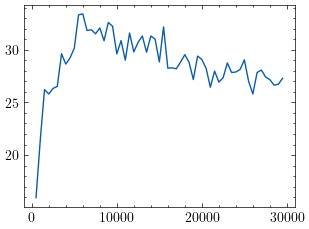

In [85]:
plt.plot(times, importances)

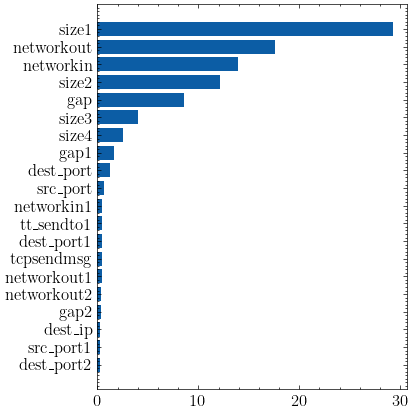

In [50]:
from catboost import Pool, EFstrType

train_pool = Pool(df)
features = pd.DataFrame({'feature_importance': model.get_feature_importance(train_pool, type=EFstrType.FeatureImportance), 
                         'feature_names': df.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=True)


plt.figure(figsize=(4,5))
plt.barh(range(len(features['feature_importance'][-20:])), features['feature_importance'][-20:], align='center')
plt.yticks(range(len(features['feature_names'][-20:])), features['feature_names'][-20:])
plt.savefig("pytorch_importance_5000_20.pdf")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


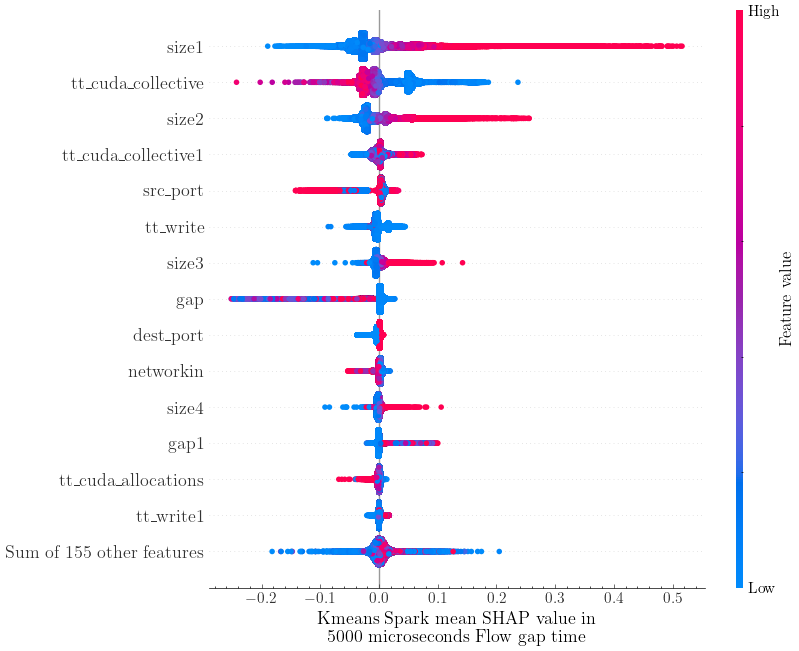

In [57]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer(df)

# visualize the first prediction's explanation
shap.plots.beeswarm(shap_values, max_display=15, show=False)
plt.xlabel("Kmeans Spark mean SHAP value in\n 5000 microseconds Flow gap time")
plt.savefig("kmeans_shap_5000.pdf", dpi=300)

In [ ]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('SHAP Importance')


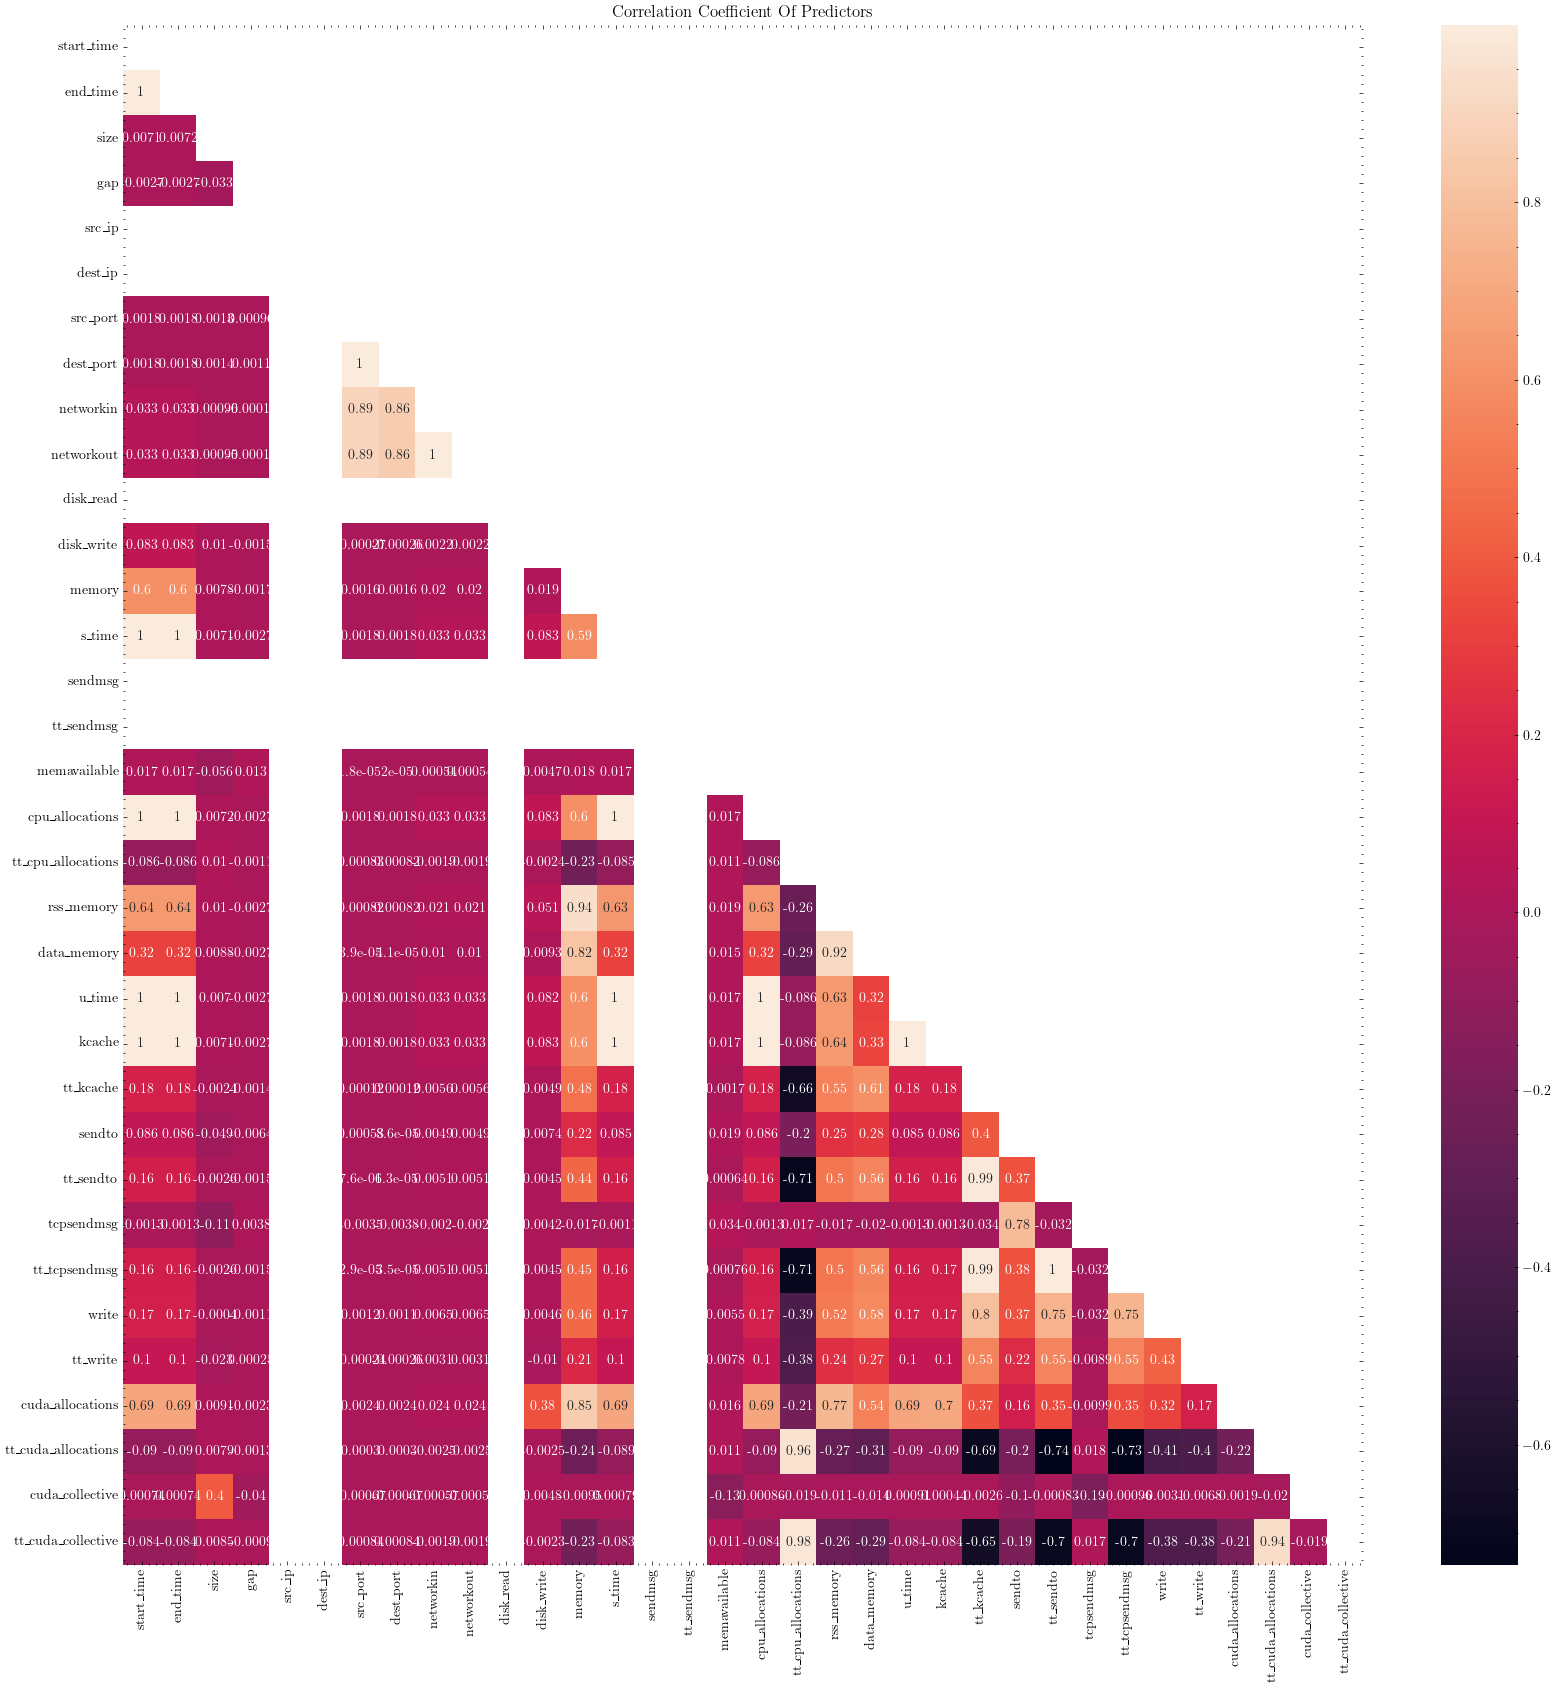

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
td = 10000
# plot heatmap
plt.figure(figsize=(20,20))

flows_df = pd.read_csv(f"{FULL_PATH}/{td}/full.csv")
# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(flows_df.corr(), dtype=bool))

# generate heatmap
sns.heatmap(flows_df.corr(), annot=True, mask=mask)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

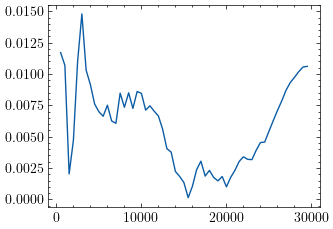

In [16]:
times = range(500, 30000, 500)
y = []
for td in times:
    flows_df = pd.read_csv(f"{FULL_PATH}/{td}/full.csv")
    m, u = flows_df.mean(), flows_df.std()
    flows_df = ((flows_df - m) / u)[flows_df.columns]
    y.append(abs(flows_df.corr()['size']['tt_cuda_collective']))
plt.plot(times, y)

In [70]:
# load packages
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

considered_features = ['land_size_sqm', 'house_size_sqm', 'no_of_rooms']
compute_vif(df.columns)

/home/morteza/.pyenv/versions/3.10.4/envs/torch/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,Variable,VIF
0,disk_read1,5.110211e+02
1,disk_write1,1.803361e+07
2,memory1,1.900062e+02
3,s_time1,1.566625e+07
4,start_time1,7.815073e+07
5,end_time1,5.806184e+03
6,gap1,1.002289e+00
7,networkin1,1.810532e+05
8,size1,1.551686e+00
9,networkout1,1.780420e+05


In [99]:
from model.ts.dataset import SequenceToSequenceDataset
from train import get_dataloaders
from torch.utils.data import DataLoader

from sklearn.metrics import (
    r2_score, mean_absolute_percentage_error
)

import torch

In [103]:
from model.ts.lstm import ShallowRegressionLSTM, SimpleLSTM
model = SimpleLSTM(len(list(flows_train.columns)), hidden_units=128).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
loss_function = torch.nn.MSELoss()

In [104]:
td = 5000
flows_df = pd.read_csv(f"{FULL_PATH}/{td}/full.csv")
flows_train, flows_test = train_test_split(
    flows_df, shuffle=False, test_size=0.3
)
m, u = flows_train.mean(), flows_train.std()
flows_train = ((flows_train - m) / u)[flows_df.columns]
flows_test = ((flows_test - m) / u)[flows_df.columns]
scaling = calculate_scaling(flows_train)
flows_train = flows_train.apply((lambda x: resize(x, scaling)), axis=0)
flows_train = flows_train.fillna(0)
flows_test = flows_test.apply((lambda x: resize(x, scaling)), axis=0)
flows_test = flows_test.fillna(0)
train_ds = SequenceToSequenceDataset(flows_train, list(flows_train.columns), 'size')
test_ds = SequenceToSequenceDataset(flows_train, list(flows_train.columns), 'size')
train_dl, test_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False), DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [105]:
num_batches = len(train_dl)
total_loss = 0
model.train()

for _ in range(20):
    total_loss = 0
    for X, y in train_dl:
        x, yy = X.cuda(), y.cuda()
        output = model(x).squeeze()
        loss = loss_function(output.flatten(), yy.flatten())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / num_batches
    print(avg_loss)

0.016235817292816354
0.014040442479094545
0.013920029587592609
0.013854538773299502
0.015021181277727523
0.0139974332494304
0.014360486824223098
0.01404608649164329
0.013999589467480407
0.014358903557962488
0.013894799992181506
0.014065852169236332
0.013875114534655312
0.01410104449858448
0.014128574492991219
0.014009751672578572
0.013845118078897085
0.013879793832796661
0.013858852371844097
0.013810376527217087


In [106]:
model.eval()

y_real = []
y_pred = []

with torch.no_grad():
    total_loss = 0
    for X, y in test_dl:
        output = model(X.cuda()).squeeze()
        loss = loss_function(output.flatten(), y.cuda().flatten())
        total_loss += loss.item()
        
        y_real.extend(output.cpu().numpy())
        y_pred.extend(y.numpy())
        
    avg_loss = total_loss / num_batches
print(avg_loss)
print(r2_score(y_real, y_pred))
print(mean_absolute_percentage_error(y_real, y_pred))

0.01565392174128782
-3.4502207555145032
18.817408


In [107]:
td = 5000
flows_df = pd.read_csv(f"{FULL_PATH_2}/{td}/full.csv")
flows_train, flows_test = train_test_split(
    flows_df, shuffle=False, test_size=0.3
)
m, u = flows_train.mean(), flows_train.std()
flows_train = ((flows_train - m) / u)[flows_df.columns]
flows_test = ((flows_test - m) / u)[flows_df.columns]
scaling = calculate_scaling(flows_train)
flows_train = flows_train.apply((lambda x: resize(x, scaling)), axis=0)
flows_train = flows_train.fillna(0)
flows_test = flows_test.apply((lambda x: resize(x, scaling)), axis=0)
flows_test = flows_test.fillna(0)
batch_size = 128
train_ds = SequenceToSequenceDataset(flows_train, list(flows_train.columns), 'size')
test_ds = SequenceToSequenceDataset(flows_train, list(flows_train.columns), 'size')
train_dl, test_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False), DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [108]:
model.eval()

y_real = []
y_pred = []

with torch.no_grad():
    total_loss = 0
    for X, y in test_dl:
        output = model(X.cuda()).squeeze()
        loss = loss_function(output.flatten(), y.cuda().flatten())
        total_loss += loss.item()
        
        y_real.extend(output.cpu().numpy())
        y_pred.extend(y.numpy())
        
    avg_loss = total_loss / num_batches
print(avg_loss)
print(r2_score(y_real, y_pred))
print(mean_absolute_percentage_error(y_real, y_pred))

0.03131894174474679
-9.223552251147396
11.354439
